In [63]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate
import numpy as np
import math
import warnings  # shut down the annoying messages
warnings.filterwarnings('ignore')  # ignore Warnings

from astroquery.sdss import SDSS
from astropy import units as u
from astropy.coordinates import SkyCoord

from jupyterthemes import jtplot
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style('onedork')#('grade3')

In [6]:
pos = SkyCoord(ra=10.625, dec=41.2, frame='icrs', unit='deg')
xid = SDSS.query_region(pos)#, data_release=7)
print(xid)

None


In [134]:
from astropy.io import fits    # read fits file
from copy import copy as copy  # avoid to change the value of pointer

# read data
nyu_fits0 = copy(fits.open('../../../download/vagc/kcorrect.nearest.petro.z0.00.fits'))
nyu_fits1 = copy(fits.open('../../../download/vagc/kcorrect.nearest.petro.z0.10.fits'))
mpa_fits = copy(fits.open('../../../download/vagc/totlgm_dr7_v5_2b.fit'))


In [137]:
mpa_fits[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.10           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                   28 /Number of bytes per row                         
NAXIS2  =               927552 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                    7 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [102]:
print(nyu_fits0[1].data.shape)
print(nyu_fits1[1].data.shape)

(2506754,)
(2506754,)


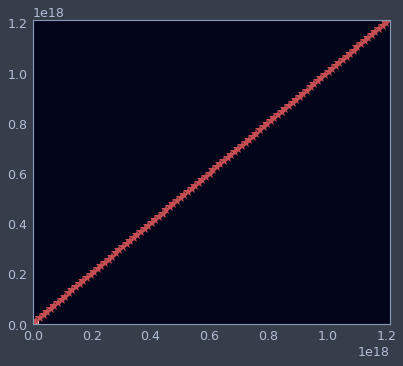

In [110]:
ra0 = nyu_fits0[1].data["RA"]
dec0 = nyu_fits0[1].data["DEC"]
ra1 = nyu_fits1[1].data["RA"]
dec1 = nyu_fits1[1].data["DEC"]
z0 = nyu_fits0[1].data["Z"]
z1 = nyu_fits1[1].data["Z"]
g0 = mag = nyu_fits0[1].data['ABSMAG'][:,1]
g1 = mag = nyu_fits1[1].data['ABSMAG'][:,1]
tmp_id = np.isinf(g0) & np.isinf(g1)
g0 = g0[~tmp_id]
g1 = g1[~tmp_id]
tmp_id = (g0>0) & (g1>0)
g0 = g0[tmp_id]
g1 = g1[tmp_id]
mass0 = nyu_fits0[1].data["mass"]
mass1 = nyu_fits1[1].data["mass"]

x = mass0
y = mass1
plt.hist2d(x,y,bins=50)
xmin,xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
plt.plot(x,x,'r*-',markersize=10)
plt.show()

In [21]:
nyu_fits0[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.4a           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  252 /Number of bytes per row                         
NAXIS2  =              2506754 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   15 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

(array([2., 1., 1., 1., 1., 0., 1., 1.]),
 array([26501.646, 26502.03 , 26502.41 , 26502.793, 26503.176, 26503.557,
        26503.94 , 26504.32 , 26504.703], dtype=float32),
 <a list of 8 Patch objects>)

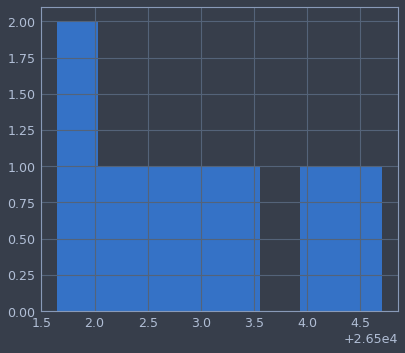

In [29]:
a = nyu_fits0[1].data['ABSMAG  '][666]
plt.hist(a,bins=8)

In [ ]:
def _stellar_mass(plateifu):
    tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
    
    ste_mass = drp_fits[1].data["NSA_ELPETRO_MASS"][tmp_id][0]
    #ste_mass = drp_fits[1].data["NSA_SERSIC_MASS"][tmp_id]
    return math.log10(ste_mass)  # change unit mass of sun to log10() mass of sun

def _mgal_mass(plateifu):
    tmp_id = (plateifu==mg_alfa_fits[1].data['plateifu'])
    if len(mg_alfa_fits[1].data['plateifu'][tmp_id])==0:
        return -999
    HI_mass = mg_alfa_fits[1].data['LOGMHI'][tmp_id][0]
    if HI_mass==-999:
        HI_mass_non = mg_alfa_fits[1].data['LOGHILIM200KMS'][tmp_id][0]
        return HI_mass_non
    else:
        return HI_mass
    pass



In [31]:
import time  # estimate running time
from copy import copy as copy  # avoid to change the value of pointer
import warnings  # shut down the annoying messages
from os.path import join  # stick different variables together
from multiprocessing import Pool  # multi-running!!!
from functools import partial  # convert to single parameter function

import math  # just for some specific calculate
import numpy as np  # array
import pandas as pd  # more powerful array
import matplotlib as mpl
import matplotlib.pyplot as plt  # plot

from astropy.io import fits    # read fits file

from marvin.tools import Maps  # use Marvin to get BPT, flux, image etc.

warnings.filterwarnings('ignore')  # ignore Warnings
from jupyterthemes import jtplot
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style('onedork')#('grade3')

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [32]:
# read data
# MaNGA-HI
mgHI_fits = copy(fits.open('../../../bak_la/root/cosmos/data/mangaHIall.fits'))
# 获取 MaNGA-ALFALFA 匹配数据，源于 MaNGA-HI 论文，无效数据为-999
mg_alfa_fits = copy(fits.open('../../../bak_la/root/cosmos/data/manga_dr15_alfalfa.fits'))
# ALFALFA
alfalfa_data = pd.read_csv('../tmp_storage/alfalfa.csv')
# match bridge
drp_fits = copy(fits.open('../../../bak_la/root/sas/dr15/manga/spectro/redux/v2_4_3/drpall-v2_4_3.fits'))
manga_Z = pd.read_pickle("../tmp_storage/MaNGA_exp_metal_spaxel.v3.0.pd.pkl")
# 取出MaNGA中的 star-forming 星系
sf_gal_plifu, sel_id = np.unique(manga_Z['plate-ifu'].values,return_index=True)
# sf_gal_plifu = manga_Z['plate-ifu'].values[sel_id]
print("4675个MaNGA星系中，有 %d 个star-forming & late-type 星系" % sf_gal_plifu.shape[0])

4675个MaNGA星系中，有 1547 个star-forming & late-type 星系


In [33]:
manga_Z

,plate-ifu,array_id,bin_id_2800,spaxel_x,spaxel_y,metallicity_pyqz,metallicity_expected,metallicity_deviation,surface_mass_density_VOR,dep_surface_mass_density,stellar_mass_global,flux_ha,flux_hb,flux_nii,flux_oii7,flux_oii9,flux_oiii
0,8252-12701,0.0,17.0,32.0,29.0,7.943745,8.436760,-0.493015,7.137067,6.945394,9.147082,4.421169,1.475151,0.215213,1.951784,2.705518,3.946412
1,8252-12701,0.0,17.0,33.0,29.0,7.925531,8.436760,-0.511229,7.137067,6.945394,9.147082,4.447966,1.522223,0.209741,2.077339,2.874850,4.018373
2,8252-12701,0.0,17.0,31.0,30.0,7.938321,8.436760,-0.498439,7.137067,6.945394,9.147082,4.457551,1.505723,0.212344,1.967339,2.832227,4.239756
3,8252-12701,0.0,17.0,32.0,30.0,7.910884,8.436760,-0.525877,7.137067,6.945394,9.147082,5.285740,1.776861,0.236909,2.322743,3.304671,5.032100
4,8252-12701,0.0,17.0,33.0,30.0,7.912759,8.436760,-0.524001,7.137067,6.945394,9.147082,5.489225,1.854484,0.245488,2.450284,3.412807,5.194313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13087397,8485-12704,4674.0,90.0,28.0,51.0,8.167562,8.379252,-0.211690,6.204077,5.945773,9.205272,3.132370,1.012403,0.359456,1.585167,2.556303,1.525136
13087398,8485-12704,4674.0,90.0,29.0,51.0,8.196554,8.379252,-0.182698,6.204077,5.945773,9.205272,2.875501,0.939855,0.331178,1.477553,2.200194,1.346209
13087399,8485-12704,4674.0,97.0,27.0,52.0,8.166965,8.397926,-0.230961,6.528677,6.270373,9.205272,2.257227,0.725440,0.266446,1.118737,1.876500,1.000097
13087400,8485-12704,4674.0,90.0,28.0,52.0,8.167792,8.379252,-0.211460,6.204077,5.945773,9.205272,2.309076,0.752262,0.270009,1.206980,1.902872,1.014256


In [37]:
plateifu = '8485-12704'
def _gal_ra_dec(plateifu):
    tmp_id = (drp_fits[1].data['plateifu']==plateifu)
    ra = drp_fits[1].data['objra'][tmp_id][0]
    dec = drp_fits[1].data['objdec'][tmp_id][0]
    return ra,dec
_gal_ra_dec(plateifu)

(233.685217665, 48.7315215591)

In [34]:
drp_fits[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1340 / length of dimension 1                          
NAXIS2  =                11465 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   99 / number of table fields                         
TTYPE1  = 'plate   '                                                            
TFORM1  = 'K       '                                                            
TTYPE2  = 'ifudsgn '                                                            
TFORM2  = '21A     '                                                            
TTYPE3  = 'plateifu'        

In [42]:
# get data
mgHI_plateifu = mgHI_fits[1].data['plateifu']
mgHI_HI_mass = mgHI_fits[1].data['logMHI']
mgHI_flux = mgHI_fits[1].data['FHI']
mgHI_snr = mgHI_fits[1].data['snr']
mgHI_rms = mgHI_fits[1].data['rms']
mgHI_Wp20 = mgHI_fits[1].data['WP20']

# alfalfa HI mass error
al_err = alfalfa_data["siglogMH"].values

# def _dis_manga(plateifu):
#     tmp_id = (drp_fits[1].data['plateifu']==plateifu)
#     redshift = drp_fits[1].data['NSA_Z'][tmp_id][0]
#     distance = cosmo.comoving_distance(z=redshift).value
#     return distance
# mgHI_dis = np.array([_dis_manga(plateifu) for plateifu in mgHI_plateifu])

# calculate HI-MaNGA HI_mass error
# mgHI_err = np.power(((1/mgHI_snr)**2),0.5) / np.log(10)
mgHI_err = np.power((mgHI_rms*1e-3 * np.power(10*1.2*mgHI_Wp20,0.5) / mgHI_flux)**2+0.1**2,0.5) / np.log(10)

In [45]:
# MaNGA-HI 中的 sf 星系
chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgHI_plateifu])
mgHI_sf_plateifu = mgHI_plateifu[chek==1]

# ALFALFA和MaNGA 匹配星系中的 sf 星系
mgal_plateifu = mg_alfa_fits[1].data['plateifu']
chek = np.array([len(sf_gal_plifu[sf_gal_plifu==plateifu]) for plateifu in mgal_plateifu])
mgal_sf_plateifu = mgal_plateifu[chek==1]

In [170]:
def _gal_ra_dec(plateifu):
    tmp_id = (drp_fits[1].data['plateifu']==plateifu)
    ra = drp_fits[1].data['objra'][tmp_id][0]
    dec = drp_fits[1].data['objdec'][tmp_id][0]
    return ra,dec
def _stellar_mass(plateifu):
    tmp_id = (plateifu==drp_fits[1].data["PLATEIFU"])
    
    ste_mass = drp_fits[1].data["NSA_ELPETRO_MASS"][tmp_id][0]
    #ste_mass = drp_fits[1].data["NSA_SERSIC_MASS"][tmp_id]
    return math.log10(ste_mass)  # change unit mass of sun to log10() mass of sun
def _al_AGC(plateifu):
    tmp_id = (plateifu==mg_alfa_fits[1].data['plateifu'])
    AGC = mg_alfa_fits[1].data['AGC'][tmp_id]
    return AGC
# def _HI_mass_err(plateifu):
#     if len(mgHI_sf_plateifu[plateifu==mgHI_sf_plateifu])==1:
#         #err = mgHI_err[mgHI_plateifu==plateifu][0]
#         err = -999
#     elif len(mgal_sf_plateifu[plateifu==mgal_sf_plateifu])==1:
#         err = al_err[_al_AGC(plateifu)==alfalfa_data['AGCNr'].values]
#     else:
#         err = -999
#     return err
def _mgal_HImass_err(plateifu):
    if len(mgal_sf_plateifu[plateifu==mgal_sf_plateifu])==1:
        err = al_err[_al_AGC(plateifu)==alfalfa_data['AGCNr'].values]
    else:
        err = -999
    return err
def _mgHI_HImass_err(plateifu):
    if len(mgHI_sf_plateifu[plateifu==mgHI_sf_plateifu])==1:
        err = mgHI_err[mgHI_plateifu==plateifu][0]
    else:
        err = -999
    return err
def _mgHI_mass(plateifu):
    tmp_id = (plateifu==mgHI_fits[1].data['plateifu'])
    if len(mgHI_fits[1].data['plateifu'][tmp_id])==0:
        return -999
    HI_mass = mgHI_fits[1].data['LOGMHI'][tmp_id][0]
    if HI_mass==-999:
        HI_mass_non = mgHI_fits[1].data['logHIlim200kms'][tmp_id][0]
        return HI_mass_non
    else:
        return HI_mass
def _mgal_mass(plateifu):
    tmp_id = (plateifu==mg_alfa_fits[1].data['plateifu'])
    if len(mg_alfa_fits[1].data['plateifu'][tmp_id])==0:
        return -999
    HI_mass = mg_alfa_fits[1].data['LOGMHI'][tmp_id][0]
    if HI_mass==-999:
        HI_mass_non = mg_alfa_fits[1].data['LOGHILIM200KMS'][tmp_id][0]
        return HI_mass_non
    else:
        return HI_mass
def _HI_mass(plateifu):
    tmp_id1 = (plateifu==mgHI_sf_plateifu)
    tmp_id2 = (plateifu==mgal_sf_plateifu)
    #print(len(mgHI_sf_plateifu[tmp_id1]))
    #print(len(mgal_sf_plateifu[tmp_id2]))
    if len(mgHI_sf_plateifu[tmp_id1])==1:
        return _mgHI_mass(plateifu)
    elif len(mgal_sf_plateifu[tmp_id2])==1:
        return _mgal_mass(plateifu)
    else:
        return -999
    pass
def _alm_galaxy(plateifu):
    # ALM 判断条件
    cri = -0.133
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    dev_Z = manga_Z['metallicity_deviation'].values[tmp_id]
    sur_density = manga_Z['dep_surface_mass_density'].values[tmp_id]
    mass = manga_Z['stellar_mass_global'].values[tmp_id]
    num_spaxels = len(dev_Z[(dev_Z <= cri)&(sur_density>7)&(mass>9)])
    return num_spaxels
# 得到单个星系的 ALM数量，sf数量，ALM/sf比值
def _alm_o_sf_spaxels(plateifu):
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    num_sf = len(manga_Z['plate-ifu'].values[tmp_id])
    num_alm = _alm_galaxy(plateifu)
    return num_alm, num_sf, num_alm / num_sf
# 泊松误差
def _possion_err_spaxel(plateifu):
    alm_num,sf_num,almosf = _alm_o_sf_spaxels(plateifu)
    err = math.sqrt(alm_num)/sf_num
    return err
# surface mass density
def _surface_desnity(plateifu):
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    density = manga_Z['surface_mass_density_VOR'].values[tmp_id][0]
    return density

alm_o_sf = np.array([_alm_o_sf_spaxels(plateifu)[2] for plateifu in sf_gal_plifu])
alm_number = np.array([_alm_o_sf_spaxels(plateifu)[0] for plateifu in sf_gal_plifu])
sf_number = np.array([_alm_o_sf_spaxels(plateifu)[1] for plateifu in sf_gal_plifu])
possion_err = np.array([_possion_err_spaxel(plateifu) for plateifu in sf_gal_plifu])
HI_mass_err = np.array([_mgal_HImass_err(plateifu) for plateifu in sf_gal_plifu])
HI_mass = np.array([_HI_mass(plateifu) for plateifu in sf_gal_plifu])
stellar_mass = np.array([_stellar_mass(plateifu) for plateifu in sf_gal_plifu])
ra_dec = np.array([_gal_ra_dec(plateifu) for plateifu in sf_gal_plifu])
mgal_sur_density = np.array([_surface_desnity(plateifu) for plateifu in sf_gal_plifu])
# flat/flatten the array 
# HI_mass_err = np.concatenate(HI_mass_err).ravel()

In [166]:
def _surface_desnity(plateifu):
    tmp_id = (manga_Z['plate-ifu'].values==plateifu)
    density = manga_Z['surface_mass_density_VOR'].values[tmp_id][0]
    return density
mgal_sur_density = np.array([_surface_desnity(plateifu) for plateifu in sf_gal_plifu])

In [171]:
print(HI_mass[HI_mass!=-999].shape)
print(HI_mass_err[HI_mass_err!=-999].shape)
print(alm_o_sf[alm_o_sf>=0].shape)
print(stellar_mass[stellar_mass>0].shape)

'''get rid of bad data [alfalfa]'''
tmp_id = copy((HI_mass_err!=-999)&(HI_mass!=-999)&(alm_number!=0))
HI_mass_err = HI_mass_err[tmp_id]
HI_mass = HI_mass[tmp_id]
stellar_mass = stellar_mass[tmp_id]
alm_o_sf = alm_o_sf[tmp_id]
alm_number = alm_number[tmp_id]
sf_number = sf_number[tmp_id]
possion_err = possion_err[tmp_id]
ra_dec = ra_dec[tmp_id]
mgal_sur_density = mgal_sur_density[tmp_id]
mgal_plateifu = sf_gal_plifu[tmp_id]

print(HI_mass[HI_mass!=-999].shape)
print(HI_mass_err[HI_mass_err!=-999].shape)
print(alm_o_sf[alm_o_sf>=0].shape)
print(stellar_mass[stellar_mass>0].shape)
print(possion_err[possion_err>=0].shape)

(536,)
(256,)
(1547,)
(1547,)
(157,)
(157,)
(157,)
(157,)
(157,)


In [165]:
a = np.concatenate(mgal_sur_density)
a.shape

(102836,)

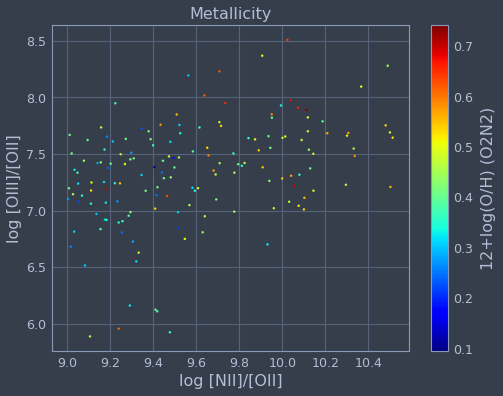

'with extinction correction'

In [175]:
import math  # just for some specific calculate
import numpy as np  # array
import pandas as pd  # more powerful array
import matplotlib as mpl
import matplotlib.pyplot as plt  # plot
# 检查数据是否正确
'''做出pyqz计算得到金属丰度的分布图
'''
# 金属丰度分布图.
# import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
# 设置colorbar颜色样式，可以在下面网站查询：
# https://matplotlib.org/tutorials/colors/colormaps.html
cm = plt.cm.get_cmap('jet')  #('nipy_spectral')
x = stellar_mass
y = mgal_sur_density
z = mgal_g_r
# 开始画散点图
sc = plt.scatter(x, y,c=z, cmap=cm,s=5)#,vmin=8, vmax=8.9, s=5, )
# # 开始画grid格子
# for i in range(7):
#     xx=locals()['line'+str(i+1)+'x']
#     yy=locals()['line'+str(i+1)+'y']
#     plt.plot(xx,yy,'o-',color='black',markerfacecolor='white')
# 坐标轴范围调整
# plt.xlim(-1.9, 0.7)
# plt.ylim(-2.0, 0.8)
# 坐标轴标题设置
plt.xlabel('log [NII]/[OII]',fontsize=16)    # x轴标签
plt.ylabel('log [OIII]/[OII]',fontsize=16)    # y轴标签
plt.tick_params(which='both',direction='in')
# colorbar调整
cbar = plt.colorbar(sc)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("12+log(O/H) (O2N2)",fontsize=16,labelpad=8)
plt.title('Metallicity',fontsize=16)
plt.show()
'''with extinction correction'''

<Figure size 576x432 with 0 Axes>

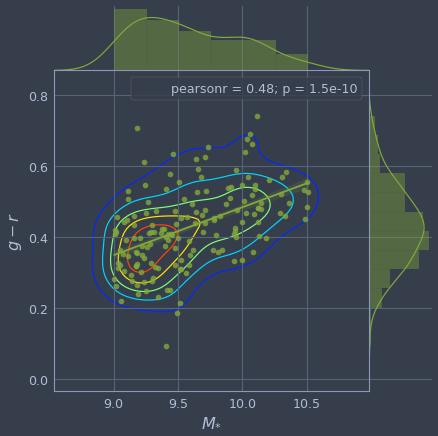

In [180]:
x = stellar_mass
y = mgal_g_r

# 散点图
plt.figure(figsize=(8,6))
# la = sns.jointplot(x,y,space=0,color='g')
la = sns.jointplot(x,y,space=0,kind="reg", color='g',ci=68)

# 等高线图
la = la.plot_joint(sns.kdeplot, zorder=0, n_levels=6,cmap="jet",linewidth=10)

# details
la.set_axis_labels(r"$M_{*}$", '$g-r$', fontsize=16)
la.annotate(stats.pearsonr)
plt.show()

<Figure size 576x432 with 0 Axes>

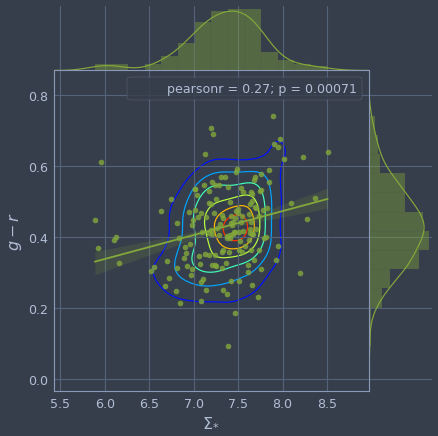

<Figure size 576x432 with 0 Axes>

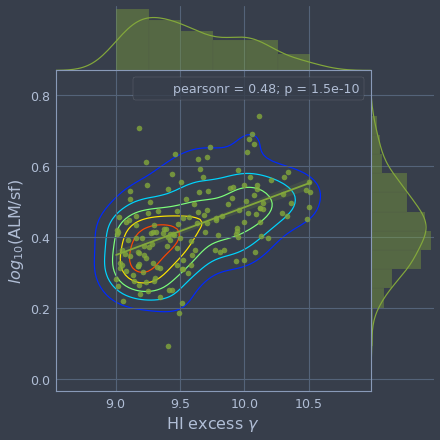

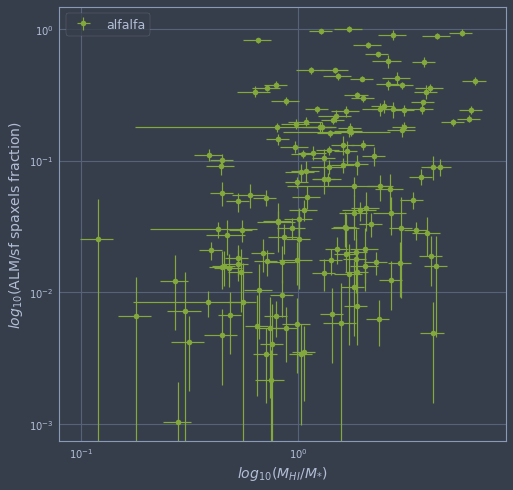

In [50]:
# variables prepared for plotting.
x = np.power(10,HI_mass-stellar_mass)
y = alm_o_sf
x_err = (np.power(10,HI_mass+HI_mass_err) - np.power(10,HI_mass)) / np.power(10,stellar_mass)
y_err = possion_err

# plot
plt.figure(figsize=(8,8))
plt.errorbar(x,y,xerr=x_err,yerr=y_err,fmt='o',color='g',label="alfalfa")#,fmt='o')
# x = np.power(10,mgHI_HI_mass-mgHI_stellar_mass)
# y = mgHI_alm_o_sf
# x_err = np.power(10,mgHI_HI_mass_err-mgHI_stellar_mass)
# y_err = mgHI_possion_err
# plt.errorbar(x,y,xerr=x_err,yerr=y_err,fmt='o',color='orange',label="HI-MaNGA")#,fmt='o')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(np.power(10,tmp_xlim))
# plt.ylim(np.power(10,tmp_ylim))

plt.tick_params(which='both',direction='in')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$log_{10}(M_{HI}/M_{*})$",fontsize=14)
plt.ylabel("$log_{10}$(ALM/sf spaxels fraction)",fontsize=14)
plt.legend(loc="best")
plt.show()

In [51]:
mgal_ra = ra_dec[:,0]
mgal_dec  = ra_dec[:,1]

nyu_ra = nyu_fits0[1].data['RA']
nyu_dec = nyu_fits0[1].data['DEC']



coo_nyu = SkyCoord(nyu_ra*u.deg, nyu_dec*u.deg)
coo_mgal = SkyCoord(mgal_ra*u.deg, mgal_dec*u.deg)

idx_nyu, d2d_nyu, d3d_nyu = coo_mgal.match_to_catalog_sky(coo_nyu)

def _g_r(nyu_id):
    mag = nyu_fits0[1].data['ABSMAG'][nyu_id]  # ugrizJHK
    g = mag[1]
    r = mag[2]
    return g-r
mgal_g_r = np.array([_g_r(tmp_id) for tmp_id in idx_nyu])

In [53]:
def _exp_f_HI(g_r,M):
    f_HI = -0.328 * math.log10(M) - 1.492*g_r + 3.662
    return f_HI

def _HIexcess(HI, stellar_mass, g_r):
    f_HI = HI/stellar_mass
    average_f_HI = _exp_f_HI(g_r,stellar_mass)
    sigma_f = 0.272
    HI_excess = (math.log10(f_HI) - average_f_HI) / sigma_f
    return HI_excess


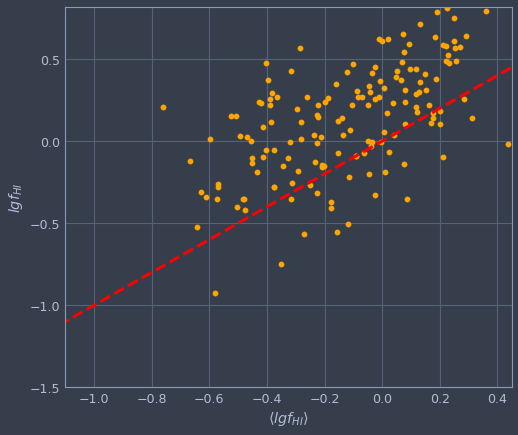

In [184]:
lg_f_HI = HI_mass - stellar_mass
ave_f_HI = np.array([_exp_f_HI(g_r,M_x) for g_r,M_x in zip(mgal_g_r,np.power(10,stellar_mass))])

x = ave_f_HI
y = lg_f_HI

plt.figure(figsize=(8,7))
plt.scatter(x,y,c='orange')
xmin,xmax = plt.xlim()
newx = np.linspace(xmin-0.3,xmax,20)
plt.plot(newx,newx,'--',c='red',linewidth=3)

plt.xlabel(r"$\langle lg f_{HI}\rangle$")
plt.ylabel(r"$lg f_{HI}$")
plt.xlim(-1.1,0.45)
plt.ylim(-1.5,0.82)
plt.show()

In [141]:
y.max()

0.8138533973914068

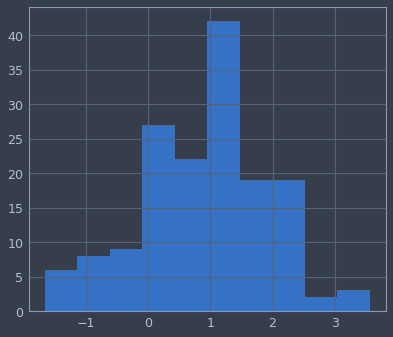

In [55]:
mgHI_excess = np.array([_HIexcess(HI,M_x,g_r) \
                        for HI,M_x,g_r in zip(np.power(10,HI_mass),np.power(10,stellar_mass),mgal_g_r)])
plt.hist(mgHI_excess)
plt.show()

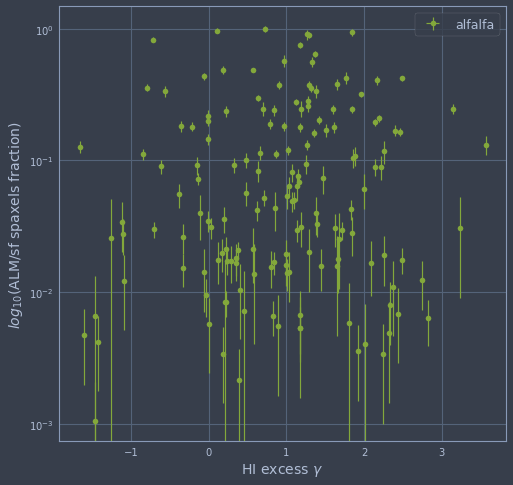

In [56]:
# variables prepared for plotting.
x = mgHI_excess  #np.power(10,HI_mass-stellar_mass)
y = alm_o_sf
x_err = 0  #(np.power(10,HI_mass+HI_mass_err) - np.power(10,HI_mass)) / np.power(10,stellar_mass)
y_err = possion_err

# plot
plt.figure(figsize=(8,8))
plt.errorbar(x,y,xerr=x_err,yerr=y_err,fmt='o',color='g',label="alfalfa")#,fmt='o')
# x = np.power(10,mgHI_HI_mass-mgHI_stellar_mass)
# y = mgHI_alm_o_sf
# x_err = np.power(10,mgHI_HI_mass_err-mgHI_stellar_mass)
# y_err = mgHI_possion_err
# plt.errorbar(x,y,xerr=x_err,yerr=y_err,fmt='o',color='orange',label="HI-MaNGA")#,fmt='o')
# plt.xscale('log')
plt.yscale('log')
# plt.xlim(np.power(10,tmp_xlim))
# plt.ylim(np.power(10,tmp_ylim))

plt.tick_params(which='both',direction='in')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(r"HI excess $\gamma$",fontsize=14)
plt.ylabel("$log_{10}$(ALM/sf spaxels fraction)",fontsize=14)
plt.legend(loc="best")
plt.show()

In [60]:
y.shape

(157,)

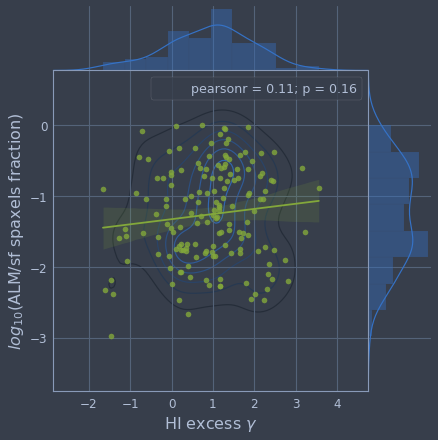

In [64]:
import seaborn as sns
from scipy import stats

# Plotting variable
x = mgHI_excess  #np.power(10,HI_mass-stellar_mass)
y = np.log10(alm_o_sf)
# y_err = possion_err/alm_o_sf/np.log(10)
# x = np.power(10,HI_mass-sf_stellar_mass)
# y = alm_o_sf
# y_err = possion_err

# Plot!!!
# la = (sns.jointplot(x,y,space=0,kind="reg").plot_joint(sns.kdeplot, zorder=0, n_levels=6))
# sns.set(style="ticks", color_codes=False)
la = (sns.JointGrid(x=x, y=y,space=0).plot_joint(sns.kdeplot, zorder=0, n_levels=6))
la= la.plot(sns.regplot,sns.distplot)

# la = sns.jointplot(np.log10(x),np.log10(y),space=0,kind="reg", color='g',ci=68)

# la = la.plot_joint(sns.kdeplot, zorder=0, n_levels=6)
# la.plot_joint(sns.regplot,color='g', ci=68,label='68%')
# plt.errorbar(x,y,yerr=y_err,fmt='o')#,fmt='o')
# ax = sns.pointplot(x,y,dodge=True, join=False, ci=None)
# print(ax.collections)
# x_coords = []
# y_coords = []
# for point_pair in ax.collections:
#     for tmp_x, tmp_y in point_pair.get_offsets():
#         x_coords.append(tmp_x)
#         y_coords.append(tmp_y)
# ax.errorbar(x_coords, y_coords, yerr=y_err, fmt=' ', zorder=-1)

# label
la.set_axis_labels(r"HI excess $\gamma$", '$log_{10}$(ALM/sf spaxels fraction)', fontsize=16)#,fontweight='bold')  
# plt.tight_layout()
# la.plot(sns.regplot, sns.distplot)
# la.plot_joint(plt.scatter,color="g", s=40, edgecolor="white")
# la.plot_joint(plt.plot,(0, 500), (0, 500), c=".2", ls="--")
# la.plot_marginals(sns.distplot, kde=False, color="g")
la.annotate(stats.pearsonr)
# la.annotate(stats.spearmanr)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.tick_params(axis="x",direction="in",pad=3)
# plt.tick_params(axis="y",direction="in",pad=3)
plt.tick_params(which='both',direction='in')

# plt.legend()
# plt.xscale('log')
# plt.yscale('log')

tmp_xlim = plt.xlim()
tmp_ylim = plt.ylim()

plt.show()

<Figure size 576x432 with 0 Axes>

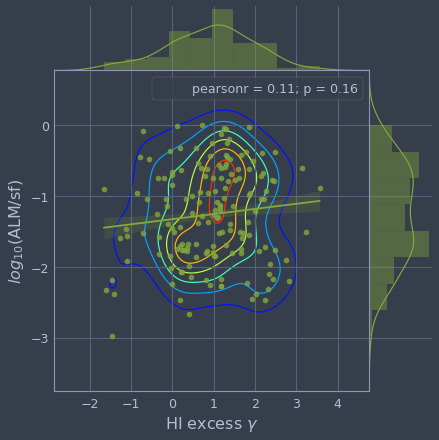

In [74]:
x = mgHI_excess  #np.power(10,HI_mass-stellar_mass)
y = np.log10(alm_o_sf)

# 散点图
plt.figure(figsize=(8,6))
# la = sns.jointplot(x,y,space=0,color='g')
la = sns.jointplot(x,y,space=0,kind="reg", color='g',ci=68)

# 等高线图
la = la.plot_joint(sns.kdeplot, zorder=0, n_levels=6,cmap="jet",linewidth=10)

# details
la.set_axis_labels(r"HI excess $\gamma$", '$log_{10}$(ALM/sf)', fontsize=16)
la.annotate(stats.pearsonr)
plt.show()